## Dataset generation using opencv

In [12]:
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import keras
import keras_metrics
import matplotlib.pyplot as plt
import os 
from random import shuffle
from tqdm import tqdm

In [ ]:
'''from numba import cuda 
device = cuda.get_current_device()
print(device)
device.reset()'''

In [22]:
#AlexNet Architecture for EC estimation
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(250,250,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1048, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4, activation='softmax')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 60, 60, 32)        3904      
_________________________________________________________________
batch_normalization_10 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 64)        51264     
_________________________________________________________________
batch_normalization_11 (Batc (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

In [ ]:
def dataset_generation():
    FaceClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    def face_detection(image):
        gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detected_face = FaceClassifier.detectMultiScale(gray_scale, 1.3, 5)
        
        if detected_face is ():
            return None
        for (x,y,w,h) in detected_face:
            face = image[y:y+h,x:x+w]
        return face
    
    videoCapture = cv2.VideoCapture(0)
    image_id = 0
    
    while True:
        ret, frame = videoCapture.read()
        if face_detection(frame) is not None:
            image_id+=1
            face = cv2.resize(face_detection(frame), (250,250))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            #Saving images from web cam to local disk
            file_name_path = "Dataset/"+"Yousaf_"+str(image_id)+'.jpg'
            cv2.imwrite(file_name_path, face)
            cv2.putText(face, str(image_id), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2 )
            cv2.imshow("Cropped_Face", face)
            if cv2.waitKey(1)==13 or int(image_id)==1000:
                break
                
    videoCapture.release()
    cv2.destroyAllWindows()
    print("Data Collection is completed")

In [ ]:
dataset_generation()

In [14]:
import numpy as np

In [15]:
#Creating labels for each person
def label(image):
    name = image.split("_")[0]
    #One hot encoding for four persons 
    if name == "Yousaf":
        return 0
    elif name == "Qazi":
        return 1
    elif name == "Abdullah":
        return 2
    elif name == "Manzoor":
        return 3

## Preparing dataset for deep learning model

In [16]:
def load_data():
    dataset = []
    for image_name in tqdm(os.listdir("C:\\Users\\Mahmood Yousaf\\Pictures\\FaceID-Door-Lock-System\\Source_Code\\Dataset")):
        image_path = os.path.join("C:\\Users\\Mahmood Yousaf\\Pictures\\FaceID-Door-Lock-System\\Source_Code\\Dataset",image_name)
        image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)/256
        dataset.append([image,label(image_name)])
    shuffle(dataset)
    return dataset

In [17]:
dataset = load_data()

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 340.16it/s]


In [18]:
dataset[1]

[array([[0.53125   , 0.53125   , 0.53515625, ..., 0.21484375, 0.2109375 ,
         0.2109375 ],
        [0.53125   , 0.53125   , 0.53125   , ..., 0.203125  , 0.20703125,
         0.20703125],
        [0.53125   , 0.53125   , 0.53125   , ..., 0.19921875, 0.19921875,
         0.19921875],
        ...,
        [0.24609375, 0.24609375, 0.25      , ..., 0.13671875, 0.13671875,
         0.140625  ],
        [0.24609375, 0.25      , 0.25390625, ..., 0.12890625, 0.1328125 ,
         0.14453125],
        [0.24609375, 0.25      , 0.25390625, ..., 0.125     , 0.13671875,
         0.1484375 ]]),
 3]

In [19]:
#Splitting dataset into training and testing 
train_dataset = dataset[:1600]
test_dataset = dataset[1600::]
X = np.array([k[0] for k in train_dataset]).reshape(-1,250,250,1)
print(X.shape)
Y = [j[1] for j in train_dataset]
Y = to_categorical(Y)
X_test = np.array([k[0] for k in test_dataset]).reshape(-1,250,250,1)
print(X_test.shape)
Y_test = [j[1] for j in test_dataset]
Y_test = to_categorical(Y_test)


(1600, 250, 250, 1)
(400, 250, 250, 1)


## CNN architecture for face recognition

In [20]:
print(Y[0])

[1. 0. 0. 0.]


In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])
history=model.fit(X, Y, epochs=20, batch_size=32, verbose=1, validation_split=0.3)

Epoch 1/20
35/35 [==============================] - 10s 269ms/step - loss: 0.0317 - accuracy: 0.9955 - precision: 0.9977 - recall: 1.0000 - f1_score: 0.9989 - val_loss: 3.7419 - val_accuracy: 0.8396 - val_precision: 0.9957 - val_recall: 0.9930 - val_f1_score: 0.9944
Epoch 2/20
35/35 [==============================] - 9s 258ms/step - loss: 0.0258 - accuracy: 0.9964 - precision: 0.9943 - recall: 0.9896 - f1_score: 0.9919 - val_loss: 1.7180 - val_accuracy: 0.9417 - val_precision: 0.9905 - val_recall: 0.9863 - val_f1_score: 0.9884
Epoch 3/20
35/35 [==============================] - 9s 256ms/step - loss: 0.0045 - accuracy: 0.9991 - precision: 0.9905 - recall: 0.9870 - f1_score: 0.9887 - val_loss: 17.1039 - val_accuracy: 0.7229 - val_precision: 0.9919 - val_recall: 0.9833 - val_f1_score: 0.9876
Epoch 4/20
35/35 [==============================] - 9s 255ms/step - loss: 0.1336 - accuracy: 0.9893 - precision: 0.9920 - recall: 0.9786 - f1_score: 0.9853 - val_loss: 4.5461 - val_accuracy: 0.8500 - 

35/35 [==============================] - 9s 257ms/step - loss: 0.0172 - accuracy: 0.9973 - precision: 0.9899 - recall: 0.9885 - f1_score: 0.9892 - val_loss: 0.6928 - val_accuracy: 0.9771 - val_precision: 0.9900 - val_recall: 0.9883 - val_f1_score: 0.9892
Epoch 18/20
35/35 [==============================] - 9s 260ms/step - loss: 0.0028 - accuracy: 0.9991 - precision: 0.9903 - recall: 0.9881 - f1_score: 0.9892 - val_loss: 0.7579 - val_accuracy: 0.9771 - val_precision: 0.9905 - val_recall: 0.9878 - val_f1_score: 0.9892
Epoch 19/20
35/35 [==============================] - 9s 262ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.9908 - recall: 0.9875 - f1_score: 0.9891 - val_loss: 0.1352 - val_accuracy: 0.9875 - val_precision: 0.9910 - val_recall: 0.9876 - val_f1_score: 0.9893
Epoch 20/20
35/35 [==============================] - 9s 256ms/step - loss: 1.0644e-10 - accuracy: 1.0000 - precision: 0.9913 - recall: 0.9877 - f1_score: 0.9895 - val_loss: 1.1455e-04 - val_accuracy: 1.0000 

In [24]:
model.evaluate(X_test,Y_test,verbose=1)

13/13 [==============================] - 2s 74ms/step - loss: 5.0664e-09 - accuracy: 1.0000 - precision: 0.9916 - recall: 0.9882 - f1_score: 0.9899


[5.06639041830681e-09,
 1.0,
 0.9916210174560547,
 0.9882335662841797,
 0.9899243116378784]

In [25]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


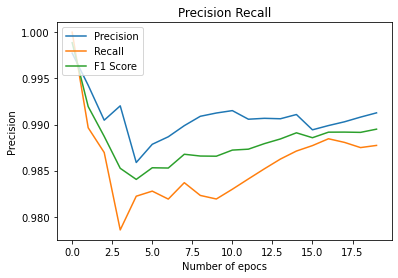

In [26]:
print(history.history.keys())
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['f1_score'])
plt.title('Precision Recall')
plt.ylabel('Precision')
plt.xlabel('Number of epocs')
plt.legend(['Precision', 'Recall','F1 Score'], loc='upper left')
plt.show()

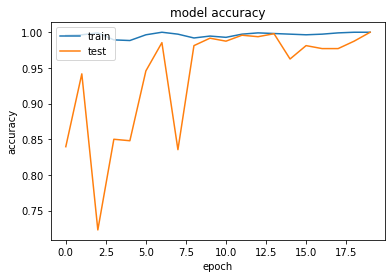

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

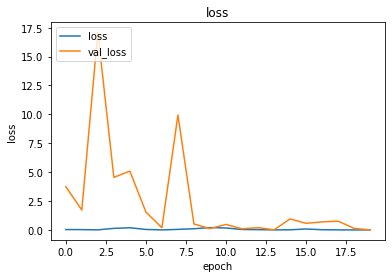

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()

In [29]:
# saving and loading the model weights
 
# save model
model.save_weights('faceRecognitionModel')
print('Model Saved!')
 
# load model
savedModel = model.load_weights('faceRecognitionModel')
print('Model Loaded!')

Model Saved!
Model Loaded!


In [ ]:
#AlexNet Architecture for EC estimation
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(250,250,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1048, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4, activation='softmax')
])
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])


In [ ]:
# load model
savedModel = model2.load_weights('faceRecognitionModel')
print('Model Loaded!')

In [ ]:
import tensorflow as tf
tf.__version__


In [ ]:
model2.evaluate(X_test,Y_test,verbose=1)

In [30]:
def prediction_model():
    FaceClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    def face_detection(image):
        gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detected_face = FaceClassifier.detectMultiScale(gray_scale, 1.3, 5)
        
        if detected_face is ():
            return None
        for (x,y,w,h) in detected_face:
            face = image[y:y+h,x:x+w]
        return face
    
    videoCapture = cv2.VideoCapture(0)    
    while True:
        ret, frame = videoCapture.read()
        if face_detection(frame) is not None:
            face = cv2.resize(face_detection(frame), (250,250))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            cv2.putText(face, str("Recognising"), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2 )
            cv2.imshow("Cropped_Face", face)
            prediction = model2.predict(face.reshape(-1, 250, 250, 1))
            print(prediction)
            if cv2.waitKey(1)==13:
                break
                
    videoCapture.release()
    cv2.destroyAllWindows()
    print("Data Collection is completed")

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\MAHMOO~1\AppData\Local\Temp/ipykernel_1892/3340609045.py:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if detected_face is ():


In [33]:
prediction = model.predict(X_test[90].reshape(-1, 250, 250, 1))

In [34]:
print(prediction)
print(Y_test[90])

[[0. 1. 0. 0.]]
[0. 1. 0. 0.]


In [35]:
prediction_model()

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
